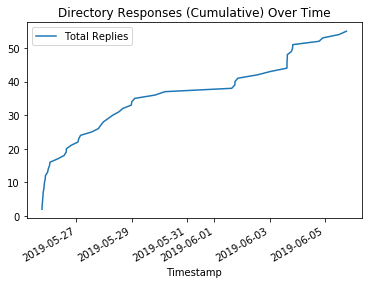

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


import datetime
import dateutil.parser as parser
import time
import re
from difflib import SequenceMatcher
import pygsheets

try:
    from nltk.tokenize import sent_tokenize, word_tokenize 
except:
    !pip install -U nltk
    from nltk.tokenize import sent_tokenize, word_tokenize 
import warnings 
  
warnings.filterwarnings(action = 'ignore') 

from dateutil.parser import parse

def flatten(S):
    if S == []:
        return S
    if isinstance(S[0], list):
        return flatten(S[0]) + flatten(S[1:])
    return S[:1] + flatten(S[1:])

def kde_max(s, mode='discreet', resolution=1000):
    #Takes sequential float-castable data and returns the
    #value associated with the maximum density.
    c = s.name
    vals = s.apply(float).dropna()
    
    if mode=='discreet':
        density = grad_year.apply(kde(vals)).rename('Density')\
        .map(lambda x: x[0])

        peak = pd.concat([vals,density], axis=1)\
        .sort_values('Density', ascending=False).iloc[0][c]

        return peak
    elif mode=='continuous':
        x = pd.Series(np.linspace(min(vals), max(vals), resolution))\
            .rename('x')
        y = x.apply(kde(vals)).rename('y').map(lambda x: x[0])
        peak = pd.concat([x,y], axis=1).sort_values('y', ascending=False)\
            .iloc[0]['x']
        return peak


#Load sheet.
gc = pygsheets.authorize(client_secret='client_secret.json')
url = 'https://docs.google.com/spreadsheets/d/14GqO9bnXG0ez6w9ZBakn6iHCN9ZKW6QFoK-QXDBDmE8/edit#gid=708166245'
name = 'Form Responses 1'
sheet = gc.open_by_url(url)
data = sheet.worksheet_by_title(name).get_as_df().dropna()

#Process sheet
data = data[data['Industry'].str.len() > 1]
data['Timestamp'] = data['Timestamp'].apply(parse)
data['Graduation Year'] = data['Graduation Year'].convert_objects(convert_numeric=True)
data = data.sort_values('Timestamp')

'''GET Responses Fig'''

data['count_values'] = 1
data['Total Replies'] = data['count_values'].cumsum()
ax = data[1:].plot('Timestamp', 'Total Replies')
plt.title('Directory Responses (Cumulative) Over Time')
fig = ax.get_figure()
fig.savefig('dir_responses_over_time.png')

#Lists unique occupations
#pd.Series(np.unique(flatten([word_tokenize(i) for i in data['Position/Occupation Description'].values])))

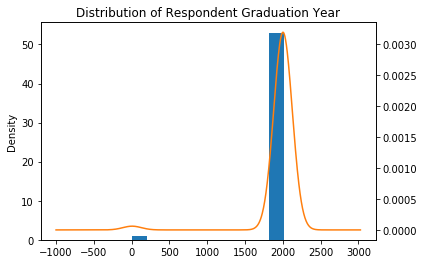

In [3]:
'''Show Grad Year Distribution'''

fig, ax1 = plt.subplots()
data['Graduation Year'].plot(kind='hist', ax=ax1)
data['Graduation Year'].plot(kind='kde', ax=ax1, secondary_y=True)
plt.title('Distribution of Respondent Graduation Year')
fig.savefig('grad_year_dist.png')

In [129]:
kde_max(data['Graduation Year'], mode='continuous', resolution=100)

2008.5454545454545

In [52]:
industry_attrs = ['Dance','Music', 'Media', 'Musical', 
         'Performance','Theatre', 'Production', 
         'Writing', 'Arts', 'Performing']
occupation_attrs = ['Actor', 'Composer', 'Composer-lyricist', 'Creative', 'Director',
       'Events', 'Producer',
       'Producer/Director/Editor',
       'Singer', 'Songwriter', 'Writer',
       'Writer/Director',
       'arranger', 'director', 'film', 'music',
       'performer', 'producer', 'teacher', 'writer']

email_permissible = ['All information visible to all alumni.',
                     'All information visible to all SIE alumni.',
                     'All information visible, only to other SIE members IN THIS DIRECTORY.']

result = data[(data['Industry'].str.contains('|'.join(industry_attrs)) 
              | data['Position/Occupation Description'].str.contains('|'.join(occupation_attrs))
              ) & (data['How visible do you want your information to be?'].isin(email_permissible)) 
             ]

contacted = ['mgbvox@gmail.com', 'hi@margaretshear.com', 'jonnyk.llc@gmail.com', 'lori@loridorr.com', 'erika.y.ji@gmail.com', 'rr@digitallaundry.net', 'MYC219@NYU.EDU', 'aronnebu@gmail.com', 'jleighweiss@gmail.com', 'betsy@rustleworks.com', 'catherinecyu0408@gmail.com', 'Frank@FrankKilpatrick.com', 'jaytreesf@gmail.com', 'willabrock@gmail.com', 'bill@jeakle.com', 'kevinshenactor@gmail.com', 'zachary@thacherinteractive.com', 'Robertleepoolethethird@gmail.com']
result[(~data['Email'].isin(contacted))]

result[result['Graduation Year'] > 2013]

,Timestamp,First Name,Last Name,Graduation Year,Degree,Company,Industry,Position/Occupation Description,What opportunities are you looking for? What advice might you be seeking from others in this group?,What things can you bring to the group to help others and foster community?,...,Facebook Profile (Optional),How visible do you want your information to be?,,,,,,,count_values,Total Replies
0,2019-03-26 19:44:29,Matthew,Billman,2015.0,Human Biology,CONSTRUCT,Music Performance,"CTO, Singer, Composer, Producer","Finding a job, Networking, Advice, 1-on-1 conv...","Finding a job, Networking, Advice, 1-on-1 conv...",...,matt.billman.90,All information visible to all alumni.,,,,,,,1,1
4,2019-05-25 18:34:04,Erika,Ji,2014.0,BS Computer Science,Erika Ji Music,"Music, Theatre, Performance, Musical Theatre W...",Composer-lyricist and performer,"Networking, 1-on-1 conversations","None of the above, I'm very early in my career...",...,https://facebook.com/erika.y.ji,All information visible to all SIE alumni.,,,,,,,1,5
8,2019-05-25 19:50:10,Alexander,Ronneburg,2017.0,"Music, Science, and Technology",Freelance,"Music, Theatre, Performance","Composer, arranger, music director, producer","Finding a job, Networking, Advice, 1-on-1 conv...","Finding a job, Networking, Advice, 1-on-1 conv...",...,,All information visible to all SIE alumni.,,,,,,,1,9
14,2019-05-26 00:32:14,Willa,Brock,2014.0,Art History and Archaeology,Bryant Park Corporation,"Music, Theatre, Dance, Free outdoor performing...",Events and Programming Associate,"Finding a job, Networking, Advice, 1-on-1 conv...","Finding a job, Networking, Advice, 1-on-1 conv...",...,,All information visible to all SIE alumni.,,,,,,,1,15
19,2019-05-26 15:11:59,Robert,Poole,2015.0,Bachelor of Science,Actor,"Theatre, Performance","Actor, Writer","Finding a job, Networking, Advice, 1-on-1 conv...","Networking, 1-on-1 conversations, Event organi...",...,,All information visible to all SIE alumni.,,,,,,,1,20
28,2019-05-28 03:29:41,Annie,Sherman,2014.0,BA Music,Performer - Freelance,"Music, Theatre, Dance, Performance","Actress, singer, dancer - primarily musical th...","Finding a job, Networking","Networking, Advice",...,,All information visible to all SIE alumni.,,,,,,,1,29
36,2019-05-30 04:54:09,Jessica,Waldman,2015.0,B.A. in Drama and French,N/A (I'm a freelance actor),"Film, TV, Theatre, Performance",Actor,"Finding a job, Networking, Advice, 1-on-1 conv...","Networking, 1-on-1 conversations",...,https://www.facebook.com/jesswaldman,All information visible to all SIE alumni.,,,,,,,1,37
41,2019-06-02 13:19:41,Grace,Wallis,2020.0,Human Biology,Undergraduate,"Film, TV, Music, Theatre, Digital Media, Perfo...","actor, director, writer, ecologist, environmen...","Finding a job, Networking, Advice, 1-on-1 conv...","Finding a job, Networking, Advice, 1-on-1 conv...",...,,All information visible to all SIE alumni.,,,,,,,1,42
47,2019-06-03 15:24:30,Zoe,Sonnenberg,2018.0,"English/Creative Writing, minor in TAPS",Sacks and Company,"Music, Theatre, Dance",I currently work as a publicist at a performin...,"Finding a job, Networking, Advice, 1-on-1 conv...","Networking, Advice, 1-on-1 conversations",...,,All information visible to all SIE alumni.,,,,,,,1,48


AttributeError: 'AxesSubplot' object has no attribute 'max'

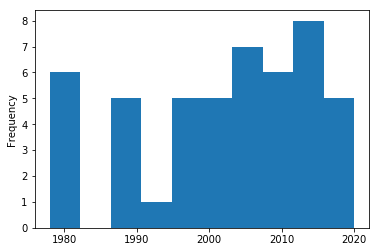

In [34]:
data['Graduation Year'].plot.hist().max()